### Tugas

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Jumlah cluster (tanpa noise): 2
Banyaknya noise: 2
Adjusted Rand Index (non-noise): 0.5484194032210918
Normalized Mutual Info (non-noise): 0.6943931497397514


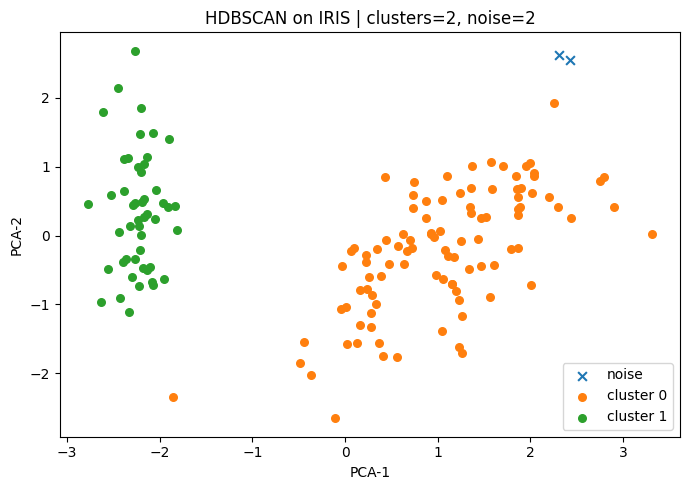

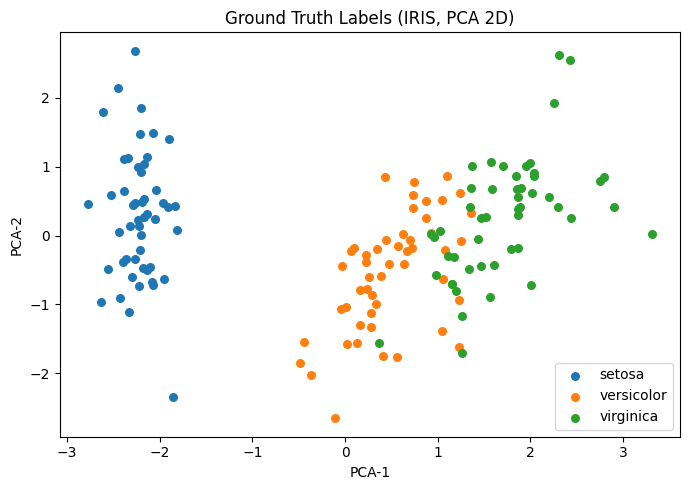

In [ ]:
# --- Setup
!pip install -q hdbscan

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import hdbscan

# --- 1) Load dataset nyata: IRIS
data = load_iris()
X = data.data                 # (150, 4)
y_true = data.target          # 3 kelas: setosa, versicolor, virginica
target_names = data.target_names

# --- 2) Standarisasi fitur (penting untuk clustering berbasis jarak)
X_scaled = StandardScaler().fit_transform(X)

# --- 3) HDBSCAN (atur hyperparameter dasar)
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=5)
labels = clusterer.fit_predict(X_scaled)    # -1 = noise
proba  = clusterer.probabilities_

# --- 4) Ringkasan hasil
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = int(np.sum(labels == -1))

print(f"Jumlah cluster (tanpa noise): {n_clusters}")
print(f"Banyaknya noise: {n_noise}")

# --- 5) Evaluasi terhadap label asli (abaikan noise agar fair)
mask_core  = labels != -1
labels_core = labels[mask_core]
y_core      = y_true[mask_core]

if len(np.unique(labels_core)) >= 2:
    ari = adjusted_rand_score(y_core, labels_core)
    nmi = normalized_mutual_info_score(y_core, labels_core)
else:
    ari, nmi = np.nan, np.nan

print(f"Adjusted Rand Index (non-noise): {ari}")
print(f"Normalized Mutual Info (non-noise): {nmi}")

# --- 6) Visualisasi PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(7,5))
# Default colormap dari matplotlib; -1 (noise) kita tandai dengan marker 'x'
for lab in sorted(set(labels)):
    idx = labels == lab
    if lab == -1:
        ax.scatter(X_pca[idx,0], X_pca[idx,1], marker='x', s=40, label='noise')
    else:
        ax.scatter(X_pca[idx,0], X_pca[idx,1], s=30, label=f'cluster {lab}')
ax.set_title(f"HDBSCAN on IRIS | clusters={n_clusters}, noise={n_noise}")
ax.set_xlabel("PCA-1")
ax.set_ylabel("PCA-2")
ax.legend()
plt.tight_layout()
plt.show()

# --- 7) (Opsional) Visualisasi label asli untuk pembanding
fig, ax = plt.subplots(figsize=(7,5))
for c in np.unique(y_true):
    idx = y_true == c
    ax.scatter(X_pca[idx,0], X_pca[idx,1], s=30, label=target_names[c])
ax.set_title("Ground Truth Labels (IRIS, PCA 2D)")
ax.set_xlabel("PCA-1")
ax.set_ylabel("PCA-2")
ax.legend()
plt.tight_layout()
plt.show()


Berikut penjelasan hasil yang kamu dapat:

# Ringkasan hasil

* **Dataset**: Iris (150 sampel, 4 fitur, 3 kelas asli: setosa, versicolor, virginica).
* **Algoritma**: HDBSCAN (fit pada data yang telah distandardisasi, visualisasi pada ruang **PCA 2D**).
* **Output inti**:

  * **Jumlah cluster (tanpa noise)**: **2**
  * **Banyaknya noise**: **2** sampel (label **-1**)
  * **ARI (non-noise)**: **0.548**
  * **NMI (non-noise)**: **0.694**

# Membaca plot

* **Plot 1 (HDBSCAN on IRIS | clusters=2, noise=2)**
  Terlihat dua kelompok utama + 2 titik **X** (noise) di area kanan-atas.

  * **cluster 1 (hijau, kiri)**: ini hampir pasti **setosa** di Iris, setosa sangat terpisah dari dua kelas lain.
  * **cluster 0 (oranye, kanan)**: gabungan **versicolor + virginica**; kedua kelas ini memang saling tumpang-tindih di beberapa fitur sehingga wajar tergabung oleh metode berbasis kepadatan.
* **Plot 2 (Ground Truth)**
  Menguatkan interpretasi: setosa terpisah jelas di kiri; versicolor (oranye) dan virginica (hijau) bercampur di sisi kanan. Dua titik yang diberi label noise oleh HDBSCAN tampak sebagai outlier di kanan-atas.

# Makna metrik

* **Adjusted Rand Index = 0.548** (pada sampel non-noise).
  ARI mengukur kesesuaian partisi dengan label asli setelah mengoreksi kebetulan (0=acak, 1=sempurna). Nilai ~0.55 menunjukkan **kecocokan sedang**: setosa cocok, tetapi penggabungan versicolor+virginica menurunkan skor.
* **Normalized Mutual Information = 0.694**.
  NMI mengukur informasi bersama antara klaster dan label (0–1). Nilai ~0.69 artinya **informasi label cukup tertangkap**, meskipun tidak sepenuhnya memisah 3 kelas.

# Analisis singkat: sesuai kah dengan label asli?

* **Sebagian sesuai.**
  HDBSCAN menemukan **setosa** sebagai klaster stabil terpisah (sesuai label asli), namun **menggabungkan versicolor & virginica** menjadi satu klaster karena kepadatan keduanya saling tumpang tindih pada ruang fitur (terlihat jelas di PCA).
* **Noise = 2** titik: HDBSCAN memperlakukan outlier sebagai noise; secara intuitif ini masuk akal karena dua titik berada jauh dari “pulau kepadatan” utama.

In [ ]:
!pip install -q hdbscan

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan

iris = load_iris()
X, y = iris.data, iris.target
names = iris.target_names

X_scaled = StandardScaler().fit_transform(X)

clusterer = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=5)
labels = clusterer.fit_predict(X_scaled)        # -1 = noise
proba  = clusterer.probabilities_

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(X_scaled)

df = pd.DataFrame({
    "sepal_length": X[:,0], "sepal_width": X[:,1],
    "petal_length": X[:,2], "petal_width": X[:,3],
    "true_id": y, "true_name": [names[i] for i in y],
    "hdb_label": labels, "probability": proba,
    "pca1": Xp[:,0], "pca2": Xp[:,1]
})
df.head(10)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,sepal_length,sepal_width,petal_length,petal_width,true_id,true_name,hdb_label,probability,pca1,pca2
0,5.1,3.5,1.4,0.2,0,setosa,1,1.000000,-2.264703,0.480027
1,4.9,3.0,1.4,0.2,0,setosa,1,1.000000,-2.080961,-0.674134
2,4.7,3.2,1.3,0.2,0,setosa,1,1.000000,-2.364229,-0.341908
3,4.6,3.1,1.5,0.2,0,setosa,1,1.000000,-2.299384,-0.597395
4,5.0,3.6,1.4,0.2,0,setosa,1,1.000000,-2.389842,0.646835
5,5.4,3.9,1.7,0.4,0,setosa,1,0.796353,-2.075631,1.489178
6,4.6,3.4,1.4,0.3,0,setosa,1,0.799775,-2.444029,0.047644
7,5.0,3.4,1.5,0.2,0,setosa,1,1.000000,-2.232847,0.223148
8,4.4,2.9,1.4,0.2,0,setosa,1,0.731684,-2.334640,-1.115328
9,4.9,3.1,1.5,0.1,0,setosa,1,1.000000,-2.184328,-0.469014


In [ ]:
ct = pd.crosstab(df["true_name"], df["hdb_label"], dropna=False)
ct = ct.reindex(columns=sorted(ct.columns))   # urutkan kolom: -1, 0, 1, ...
ct


hdb_label,-1,0,1
true_name,,,
setosa,0,1,49
versicolor,0,50,0
virginica,2,48,0


In [ ]:
ambiguous = df[df["hdb_label"] != -1].nsmallest(12, "probability")
ambiguous[["true_name","hdb_label","probability","pca1","pca2","petal_length","petal_width"]]


,true_name,hdb_label,probability,pca1,pca2,petal_length,petal_width
41,setosa,0,0.316144,-1.858122,-2.337415,1.3,0.3
15,setosa,1,0.333427,-2.262215,2.686284,1.5,0.4
118,virginica,0,0.465274,3.310696,0.017781,6.9,2.3
60,versicolor,0,0.465275,-0.110196,-2.654073,3.5,1.0
106,virginica,0,0.481784,0.367018,-1.561503,4.5,1.7
109,virginica,0,0.482493,2.259777,1.921010,6.1,2.5
14,setosa,1,0.510125,-2.198741,1.860057,1.2,0.2
33,setosa,1,0.526277,-2.446177,2.150728,1.4,0.2
32,setosa,1,0.539744,-2.614948,1.793576,1.5,0.1
85,versicolor,0,0.540375,0.429139,0.845582,4.5,1.6


In [ ]:
noise_points = df[df["hdb_label"] == -1]
noise_points[["true_name","hdb_label","probability","pca1","pca2","petal_length","petal_width"]]


,true_name,hdb_label,probability,pca1,pca2,petal_length,petal_width
117,virginica,-1,0.0,2.426329,2.556661,6.7,2.2
131,virginica,-1,0.0,2.304928,2.626323,6.4,2.0
